## Importing Libraries

In [1]:
#!pip install spacy
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import collections
import itertools
from wordcloud import WordCloud, STOPWORDS
from matplotlib import rcParams
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk.stem as stemme


import matplotlib.pyplot as plt
%matplotlib inline
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\balakrishnanr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read data

In [2]:
df_data=pd.read_excel('LDP_PostPandemic.xlsx')

In [3]:
#Combining 3 leadership challenges into one variable
df_data["Challenge_txt"] = df_data["Leadership Challenge 1"].str.cat(df_data[["Leadership Challenge 2", "Leadership Challenge 3"]].astype(str), sep=" ")   


In [4]:
len(df_data)

1578

## Dropping null values

In [5]:
df_data=df_data.dropna(subset='Challenge_txt')

In [6]:
len(df_data)

1466

## Wordcount of Challenge data

In [7]:
df_data["Challenge_txt1"] = df_data["Leadership Challenge 1"].str.cat(df_data[["Leadership Challenge 2", "Leadership Challenge 3"]].astype(str), sep=" ")   

df_data['Word_count']=df_data['Challenge_txt1'].apply(lambda words: ' '.join(word.lower() for word in words.split()))
df_data['Word_count'] = df_data['Word_count'].str.split().str.len()

array([[<AxesSubplot:title={'center':'Word_count'}>]], dtype=object)

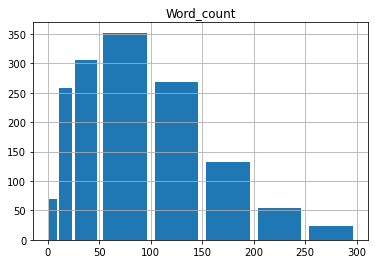

In [8]:
bins1 = [0,10,25,50,100,150,200,250,300]
df_data.hist(column="Word_count", bins=bins1, rwidth=0.85) 

In [9]:
df_data=df_data[df_data['Word_count']>10]

In [10]:
df_data.describe()

,ESI Key,Word_count
count,1.382000e+03,1382.000000
mean,7.165346e+06,84.102750
std,1.126970e+06,63.749166
min,4.419147e+06,11.000000
25%,7.577504e+06,31.000000
50%,7.625936e+06,69.000000
75%,7.653990e+06,122.000000
max,7.694752e+06,505.000000


# Data Cleaning

## Removing all characters that are not alpha

In [8]:
df_data['Challenge_txt']=df_data['Challenge_txt'].astype(str)
df_data['Challenge_txt'] = df_data['Challenge_txt'].map(lambda x: re.sub('[^a-zA-Z]'," ",x))
df_data['Challenge_txt'] = df_data['Challenge_txt'].map(lambda x: x.lower())


In [9]:
df_data.dtypes

ESI Key                            int64
Event Start Date          datetime64[ns]
Leadership Challenge 1            object
Leadership Challenge 2            object
Leadership Challenge 3            object
Challenge_txt                     object
dtype: object

In [10]:
df_data['year']=df_data['Event Start Date'].dt.year

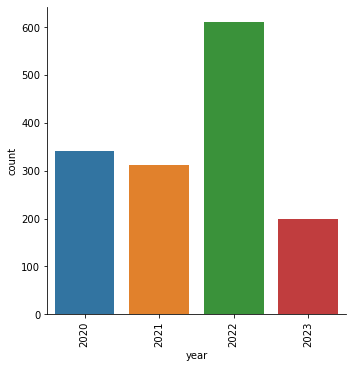

In [11]:
#Category Plot by year
q=sns.catplot(x="year", kind="count", data=df_data);

q.set_xticklabels(rotation=90)

## Lemmatization, Stop words, tokenization

In [12]:
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
customized_words = {'leadership','challenge','organization','','challenging'}
en_stop=en_stop.union(customized_words)
#stemmer = SnowballStemmer('english')

def lemma(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    allowed_tags ={'J','N','V','R'}
    if tag in allowed_tags:
        #lemma=stemmer.stem(WordNetLemmatizer().lemmatize(word))
        lemma=WordNetLemmatizer().lemmatize(word)
        return lemma
    else:
        return ''

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma 

def prepare_text_for_lda(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if len(token)> 4]    
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [lemma(token) for token in tokens]
    tokens = [get_lemma(token) for token in tokens]
    tokens = [token for token in tokens if token not in customized_words]
    return tokens
df_data['Challenge_txt']=df_data.Challenge_txt.astype(str)
df_data['Challenge_txt']= df_data['Challenge_txt'].apply(prepare_text_for_lda)

bigram = gensim.models.phrases.Phrases(df_data['Challenge_txt'] , min_count=3, threshold=10)
df_data['Challenge_txt'] =df_data['Challenge_txt'].map(lambda x: list(bigram[x]))
df_data.head(2)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balakrishnanr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balakrishnanr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ESI Key,Event Start Date,Leadership Challenge 1,Leadership Challenge 2,Leadership Challenge 3,Challenge_txt,year
0,4436422,2022-04-11,Empowering my team to advance in their careers,Identifying an effective strategic path forward.,work life balance,"[empower, advance_career, identify, effective,...",2022
1,4436781,2022-04-04,Communication. Using technology. Training staf...,Work from home or in office. Different philoso...,Office space,"[communication, using, technology, training, s...",2022


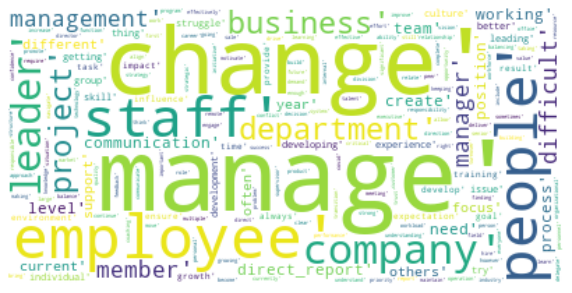

In [13]:
x = "".join(x for x in df_data.Challenge_txt.astype(str))
##For the entire corpus
wordcloud = WordCloud(background_color="white").generate(x)
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
rcParams['figure.figsize'] = 10, 50
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
#df_data['Challenge_txt_stem']=df_data['Challenge_txt']

## Creation of Corpus and dictionary

In [13]:
text_data = df_data['Challenge_txt']
dictionary = corpora.Dictionary(text_data)
dictionary.filter_extremes(no_below=5, no_above=0.5,keep_n=100000)
corpus = [dictionary.doc2bow(txt) for txt in text_data] 

## Finding optimum number of Topics

In [14]:
def comupteK(dictionary,corpus,texts,limit,start=1,step=1):
    model_list=[]
    coh_list =[]
    for k in range (start,limit,step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                        update_every=1,
                                           alpha='auto',
                                           per_word_topics=True) 
        
        
        model_list.append(model)
        coherence_mod= CoherenceModel(model=model, texts = text_data,dictionary=dictionary, coherence='c_v')
        coh_list.append(coherence_mod.get_coherence())
    return(model_list,coh_list)    
       
model_list, coh_list = comupteK(dictionary=dictionary, corpus=corpus, texts=text_data, start=1, limit=20, step=1)  

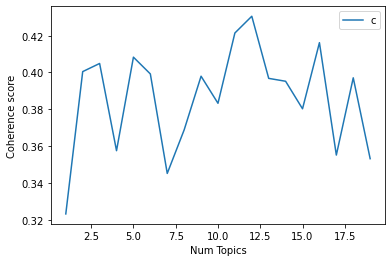

In [18]:
limit=20; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coh_list)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## HyperParameter Tuning for topics 5 -14 for alpha and beta

In [18]:
import numpy as np
alpha =  [0.05,0.1,0.5,1,5,10]
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta =  [0.05,0.1,0.5,1]
beta.append('symmetric')
Topics = range(5,14,1)
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }
for k in Topics:
    for a in alpha:
        for b in beta:
            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
            coherence_mod= CoherenceModel(model=model, texts = text_data,dictionary=dictionary, coherence='c_v')
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(coherence_mod.get_coherence())
            model_results['Perplexity'].append(model.log_perplexity(corpus))
                
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)  

In [99]:
kvaluedf2 = pd.DataFrame(model_results)   
kvaluedf2
kvaluedf2.sort_values(by='Coherence',ascending = False).head(20)

,Topics,Alpha,Beta,Coherence,Perplexity
88,7,0.1,1,0.470515,-6.400188
17,5,1,0.5,0.463164,-6.351687
113,7,symmetric,1,0.459310,-6.415581
98,7,1,1,0.457479,-6.449844
18,5,1,1,0.457019,-6.374923
57,6,1,0.5,0.454541,-6.383164
8,5,0.1,1,0.452868,-6.353039
58,6,1,1,0.450982,-6.414939
12,5,0.5,0.5,0.450623,-6.368520
3,5,0.05,1,0.450516,-6.351039


In [24]:
#Final Model

model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.5,
                                           eta=1,
                                           )
coherence_mod= CoherenceModel(model=model, texts = text_data,dictionary=dictionary, coherence='c_v')
coherence_mod.get_coherence()

0.48174546164142906

## LDA Visualization

In [25]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
res=gensimvis.prepare(model, corpus, dictionary,mds='mmds')
res

C:\Users\balakrishnanr\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.093081 -0.118878       1        1  22.403539
2     -0.022152  0.125471       2        1  20.597297
0     -0.070480 -0.132921       3        1  20.438932
4     -0.144773  0.043007       4        1  19.849013
1      0.144325  0.083322       5        1  16.711219, topic_info=          Term        Freq       Total Category  logprob  loglift
99      manage  448.000000  448.000000  Default  30.0000  30.0000
24    employee  372.000000  372.000000  Default  29.0000  29.0000
20      change  428.000000  428.000000  Default  28.0000  28.0000
12       staff  214.000000  214.000000  Default  27.0000  27.0000
39     company  240.000000  240.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
76     program   28.992571   64.342920   Topic5  -5.3795   0.9919
155       hire   29.261110   69.288045   Topic5  -5.3703   0.9271
42       level   33.792527  192.977443   Topic5  -5.2263   0.0468
106    process   31.826452  173.370564   Topic5  -5.2862   0.0940
94   difficult   29.292401  184.072839   Topic5  -5.3692  -0.0489

[282 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
514       1  0.281415  ability
514       2  0.613996  ability
514       3  0.051166  ability
514       4  0.038375  ability
514       5  0.012792  ability
...     ...       ...      ...
118       1  0.162376    young
118       2  0.040594    young
118       3  0.081188    young
118       4  0.608909    young
118       5  0.121782    young

[1120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

In [26]:
pyLDAvis.save_html(res, '5_Topic_US_LM_PP_KeywordFrequencyGraph.html')

# Create Topic Document Matrix

In [27]:
tp=model.show_topics(formatted=False)
topics_words1 = [(x[0],[y[0]for y in x[1]]) for x in tp]
topics_words1
sent_topics_df = pd.DataFrame()
for x,y in topics_words1:
    key =' '.join(y)
    sent_topics_df = sent_topics_df.append(pd.Series([str(x),key]), ignore_index=True)   
sent_topics_df

C:\Users\balakrishnanr\AppData\Local\Temp\ipykernel_18844\1083163096.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([str(x),key]), ignore_index=True)
C:\Users\balakrishnanr\AppData\Local\Temp\ipykernel_18844\1083163096.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([str(x),key]), ignore_index=True)


,0,1
0,0,manage manager direct_report management projec...
1,1,employee staff training project market covid s...
2,2,business team influence support focus ensure d...
3,3,people often better others thing difficult dec...
4,4,change company leader year create culture depa...


In [29]:
topic= [model[corpus[i]] for i in range (len(text_data))]
def doc_topicstodataframe (topics,num_topics):
    df=pd.DataFrame(columns = range(num_topics))
    for topic_weight in topics:
        df.loc[0,topic_weight[0]] = topic_weight[1]
    return df

document_topic = pd.concat([doc_topicstodataframe(topics_document, num_topics=6) for topics_document in topic]).reset_index(drop=True).fillna(0)
document_topic = document_topic.rename(columns={0:"Topic 1",1:"Topic 2",2:"Topic 3",3:"Topic 4",4:"Topic 5",5:"Topic 6",6:"Topic 7"})
document_topic['Most relevant topic']=document_topic.idxmax(axis=1)
document_topic


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Most relevant topic
0,0.206736,0.056190,0.575744,0.102500,0.058830,0,Topic 3
1,0.053621,0.545426,0.220404,0.041097,0.139451,0,Topic 2
2,0.021316,0.171728,0.478174,0.091342,0.237440,0,Topic 3
3,0.156182,0.431141,0.061373,0.104190,0.247112,0,Topic 2
4,0.204434,0.083972,0.031148,0.143331,0.537115,0,Topic 5
...,...,...,...,...,...,...,...
1461,0.044105,0.045633,0.088702,0.046105,0.775455,0,Topic 5
1462,0.169803,0.000000,0.159992,0.653252,0.000000,0,Topic 4
1463,0.391718,0.359973,0.048102,0.035288,0.164920,0,Topic 1
1464,0.708938,0.036828,0.038689,0.176817,0.038728,0,Topic 1


In [30]:
df_data=df_data.reset_index()

In [31]:

result=pd.merge(df_data,document_topic,left_index=True,right_index=True)
result

,index,ESI Key,Event Start Date,Leadership Challenge 1,Leadership Challenge 2,Leadership Challenge 3,Challenge_txt,year,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Most relevant topic
0,0,4436422,2022-04-11 00:00:00,Empowering my team to advance in their careers,Identifying an effective strategic path forward.,work life balance,"[empower, advance_career, identify, effective,...",2022,0.206736,0.056190,0.575744,0.102500,0.058830,0,Topic 3
1,1,4436781,2022-04-04 00:00:00,Communication. Using technology. Training staf...,Work from home or in office. Different philoso...,Office space,"[communication, using, technology, training, s...",2022,0.053621,0.545426,0.220404,0.041097,0.139451,0,Topic 2
2,2,4437517,2022-03-21 04:00:00,Leading a remote team where we used to be in o...,Optimizing new technology and helping staff wi...,Effectively and timely communication to the te...,"[leading, remote, office, hybrid, struggle, em...",2022,0.021316,0.171728,0.478174,0.091342,0.237440,0,Topic 3
3,3,4438149,2022-05-16 00:00:00,Trying to get enough staffing at every level a...,Getting my managers and the rest of the team t...,NaN,"[try, enough, staff, level, staff, retain, get...",2022,0.156182,0.431141,0.061373,0.104190,0.247112,0,Topic 2
4,4,4440471,2022-03-21 04:00:00,Learning a new role while also maintaining pre...,"Working with more experienced peers, superiors...",Family Business:Charlotte Pipe is my family's ...,"[learning, maintain, previous, sale, responsib...",2022,0.204434,0.083972,0.031148,0.143331,0.537115,0,Topic 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,1573,7640276,2022-03-14 00:00:00,Pay equity for my team.,Educating leadership on the work we do and our...,Executive leadership transparency/poor communi...,"[equity, educate, value, mission, university, ...",2022,0.044105,0.045633,0.088702,0.046105,0.775455,0,Topic 5
1462,1574,7640277,2022-03-14 00:00:00,Leadership Style - I want to be liked by every...,Team Management - I manage a team of 10 people...,Critical of Self - i'm very critical of myself...,"[style, like, everyone, often, someone, know, ...",2022,0.169803,0.000000,0.159992,0.653252,0.000000,0,Topic 4
1463,1575,7641623,2022-03-14 00:00:00,Managing remote employees,Maintaining a healthy work/life balance for my...,Juggling constantly changing priorities and mu...,"[manage, remote, employee, maintain, healthy, ...",2022,0.391718,0.359973,0.048102,0.035288,0.164920,0,Topic 1
1464,1576,7637878,2022-03-14 00:00:00,Providing inspiration to my colleagues to go t...,"Managing conflict between team members, and be...",Being more decisive and making decisions witho...,"[provide, inspiration, colleague, extra, manag...",2022,0.708938,0.036828,0.038689,0.176817,0.038728,0,Topic 1


In [32]:
result.to_csv('LM_Post_pandemic_results_5.csv')